## Initial setup

Validate your python environment here.

In [1]:
import gzip
import os
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
import rdkit.Chem
import rdkit.Chem.Draw


Specify some configurations for the notebook.

In [2]:
DOWNLOAD_DIR = "datasets"

SOURCES = {
    "clintox": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz",
        "file_name": "clintox.csv",
    },
    "toxcast": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/toxcast_data.csv.gz",
        "file_name": "toxcast.csv",
    },
    "pcba": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pcba.csv.gz",
        "file_name": "pcba.csv",
    },
}

Now we'll define some data loading helpers:
- `fetch_data` downloads a local copy of the files specified in `SOURCES` above.
- `load_data(name)` returns a dataframe that was extracted from the downloaded file.

Example usages can be seen below.

In [3]:
# We'll maintain a global cache of dataframes to avoid re-loading them
global DATA_CACHE
DATA_CACHE = {}


def fetch_data(source, force_redownload=False):
    # create storage path if it does not exist
    storage_path = os.path.join(DOWNLOAD_DIR, source)
    if not os.path.isdir(storage_path):
        os.makedirs(storage_path)

    # download file if it does not exist or if we want a fresh copy
    gz_file_path = os.path.join(storage_path, f"{SOURCES[source]['file_name']}.gz") 
    if not os.path.isfile(gz_file_path) or force_redownload:
        urllib.request.urlretrieve(SOURCES[source]["download_url"], gz_file_path)


def load_data(name):
    file_path = os.path.join(DOWNLOAD_DIR, name, SOURCES[name]["file_name"])

    #check if we've already loaded this data
    global DATA_CACHE
    if name in DATA_CACHE:
        return DATA_CACHE[name]

    # extract csv if we haven't already
    gz_file_path = f"{file_path}.gz"
    if not os.path.isfile(file_path):
        with gzip.open(gz_file_path, "rb") as f_in:
            with open(file_path, "wb") as f_out:
                f_out.write(f_in.read())

    data = pd.read_csv(file_path)

    # apply any initial cleaning through queries
    if name == "clintox":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass
    elif name == "toxcast":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass

    DATA_CACHE[name] = data
    return data


In [4]:
for source in SOURCES:
    fetch_data(source, force_redownload=False)

## Exploration

Starting with some basic inspection

It could help to get a better understanding of the SMILES format by comparing it to the actual molecule. Running this cell will give you a comparison for a random molecule in the toxcast dataset.

CCCC(C)C1(C(=O)NC(=S)NC1=O)CC


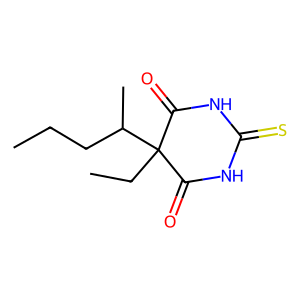

In [5]:
def random_molecule():
    clintox_data = load_data("clintox")
    return clintox_data["smiles"][np.random.randint(len(clintox_data))]

def display_molecule(molecule):
    print(molecule)
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(molecule))

display_molecule(random_molecule())

## LOAD DATA

In [8]:
## Load Data ##
df_c = load_data("clintox")
df_t = load_data("toxcast")
df_p = load_data("pcba")

In [10]:
from preprocessing.preprocessing import compute_full_preprocessing
import time

## Compute Full Preprocessing: Generate Chemistry Features and Target Column ##
"""
Target Column = 1 if any Assay Feature was positive (1)
Target Column = 0 if all Assay Features were negative (0) or Null
"""

time0 = time.time()
df_p = compute_full_preprocessing(df_p, subset_size = 0.1, dataset = "pcba")
time1 = time.time()

print(f"Time: {time1-time0}s")
df_p

[10:46:06] WARNING: not removing hydrogen atom without neighbors


<class 'pandas.core.frame.DataFrame'>


C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Original DataFrame Size: 43793
Processed DataFrame Size: 43775
Processed / Original Size Ratio: 100.0%
Time: 131.42890071868896s


,molecule,toxicity_target,radical_electrons,total_molecular_weight,avg_molecule_weight_no_hydrogens,valence_electrons,avg_molecule_weight,max_partial_charge,min_partial_charge,aliphatic_carbocycles,...,fingerprint_246,fingerprint_247,fingerprint_248,fingerprint_249,fingerprint_250,fingerprint_251,fingerprint_252,fingerprint_253,fingerprint_254,fingerprint_255
0,<rdkit.Chem.rdchem.Mol object at 0x0000025D35F...,0,0,218.080376,208.136,82,218.216,0.326791,-0.479816,0,...,0,1,0,0,0,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x0000025D329...,0,0,236.152478,216.155,94,236.315,0.242550,-0.351578,2,...,0,0,0,0,0,1,0,1,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x0000025D364...,1,0,286.036540,280.136,104,286.184,0.298137,-0.347309,0,...,0,0,0,0,0,0,0,0,0,1
3,<rdkit.Chem.rdchem.Mol object at 0x0000025D364...,0,0,429.118084,406.383,152,429.567,0.224186,-0.351739,0,...,0,0,0,0,0,1,0,0,0,1
4,<rdkit.Chem.rdchem.Mol object at 0x0000025D364...,0,0,393.129317,370.354,140,393.538,0.243483,-0.357885,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43770,<rdkit.Chem.rdchem.Mol object at 0x0000025D36C...,1,0,387.134969,365.691,142,387.867,0.254868,-0.492798,0,...,0,1,0,1,0,0,0,1,0,1
43771,<rdkit.Chem.rdchem.Mol object at 0x0000025D36C...,0,0,409.211390,382.274,158,409.490,0.318952,-0.459205,1,...,0,0,0,0,1,1,0,0,0,0
43772,<rdkit.Chem.rdchem.Mol object at 0x0000025D36C...,0,0,452.117271,427.760,162,452.960,0.251042,-0.495337,1,...,1,0,0,1,0,1,0,0,0,1
43773,<rdkit.Chem.rdchem.Mol object at 0x0000025D36C...,0,0,270.052823,260.160,100,270.240,0.335965,-0.477639,0,...,0,0,0,0,0,0,0,0,0,0


# CLUSTERING

In [11]:
### CLUSTERING HELPER FUNCTIONS ###

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

## Inertia Functions ##
def getInertia(X,kmeans_model):
    """
    This function should return the exact same value as the attribute inertia_ of kmeans
    """
    inertia = np.linalg.norm(X - kmeans_model.cluster_centers_[kmeans_model.labels_])**2
    
    return inertia

def getInertia2(X, kmeans_model):
    """
    Compute Inertia of Second Cluster
    """
    second_cluster = min(1,len(kmeans_model.cluster_centers_)-1) # Just in case there is only 1 cluster
    distance_to_center = np.sort(np.array([np.linalg.norm(X - z, axis = 1)**2 for z in kmeans_model.cluster_centers_]).T,axis=1)
    distance_to_center = np.sum(distance_to_center[:,second_cluster])
    
    return distance_to_center

def compute_cluster_inertia_silhouettes(X, max_n_clusters = 10):
    """
    Compute the Inertia and Silhouette for each kmeans model.
    """
    # Instantiate Containers for Inertias and Silhouettes
    inertias_1 = []
    inertias_2 = []
    silhouettes = []
    models = []

    # run functions for each value of k
    for k in range(1,max_n_clusters+1):
        model = KMeans(n_clusters=k).fit(X)
        inertias_1.append(getInertia(X,model))
        inertias_2.append(getInertia2(X,model))
        models.append(model)
        if k > 1:
            #silhouettes.append(silhouette_allRow(X,model)[1])
            silhouettes.append(silhouette_score(X, model.labels_, metric='euclidean'))
            
    return inertias_1, inertias_2, silhouettes, models

In [13]:
# Cluster Based on Molecular Fingerprints
fingerprint_cols = [f"fingerprint_{i}" for i in range(256)]
X = df_p[fingerprint_cols].to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1]])

In [14]:
# Generate Inertias, Silhouettes and Kmeans Models

inertias_1, inertias_2, silhouettes, kmeans_per_k = compute_cluster_inertia_silhouettes(X)

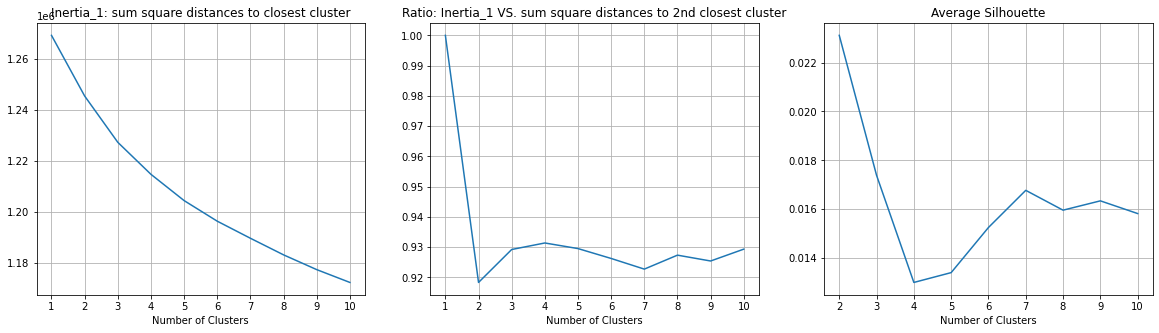

In [15]:
# Plot Inertias and Silhouettes as Function of Number of Clusters
max_k = len(inertias_1)

plt.figure(figsize=(20,5))

# Plot Inertia
plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_k+1),inertias_1)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# Plot Inertia1/Inertia2
plt.subplot(1,3,2)
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_k+1),np.array(inertias_1)/np.array(inertias_2))
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# Plot Silhouette
plt.subplot(1,3,3)
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_k+1),silhouettes)
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(2,max_k+1))
plt.grid()

plt.show()

Optimal amount of clusters appears to be 2, unsure how useful this will be for the model. Will ignore.